In [1]:
import torch
from torch.nn import functional as F
import cv2
import glob
import os
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
import numpy as np
import matplotlib.pyplot as plt


# from realesrgan import RealESRGANer

In [2]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def preprocess(img_path, pre_pad=10, mod_scale=4):
    img = cv2.imread(img_path)
    h_input, w_input = img.shape[0:2]
    # img: numpy
    img = img.astype(np.float32)
    if np.max(img) > 256:  # 16-bit image
        max_range = 65535
        print('\tInput is a 16-bit image')
    else:
        max_range = 255
    img = img / max_range
    if len(img.shape) == 2:  # gray image
        img_mode = 'L'
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA image with alpha channel
        img_mode = 'RGBA'
        alpha = img[:, :, 3]
        img = img[:, :, 0:3]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if alpha_upsampler == 'realesrgan':
            alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
    else:
        img_mode = 'RGB'
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
    img = img.unsqueeze(0).to("cpu")
    img = F.pad(img, (0, pre_pad, 0, pre_pad), 'reflect')
    
    mod_pad_h, mod_pad_w = 0, 0
    _, _, h, w = img.size()
    if (h % mod_scale != 0):
        mod_pad_h = (mod_scale - h % mod_scale)
    if (w % mod_scale != 0):
        mod_pad_w = (mod_scale - w % mod_scale)
    img = F.pad(img, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
    
    return img, mod_pad_h, mod_pad_w

def post_process(output, mod_pad_h, mod_pad_w, mod_scale=4, pre_pad=10):
    scale=1 # hardcoded for model_scale=4
    # remove extra pad
    if mod_scale is not None:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - mod_pad_h * scale, 0:w - mod_pad_w * scale]
    # remove prepad
    if pre_pad != 0:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - pre_pad * scale, 0:w - pre_pad * scale]
    # unsqueze to remove batch
    output = output.squeeze().float().cpu().clamp_(0, 1).numpy()
    # convert to channel last
    output = np.transpose(output, (1, 2, 0))
    output = (output * 255.0).round().astype(np.uint8)
    
    return output

In [3]:
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
netscale = 4
file_url = 'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth'
model_path = load_file_from_url(url=file_url, model_dir="weights", progress=True, file_name=None)
loadnet = torch.load(model_path, map_location=torch.device('cpu'))
# prefer to use params_ema
if 'params_ema' in loadnet:
    keyname = 'params_ema'
else:
    keyname = 'params'
model.load_state_dict(loadnet[keyname], strict=True)
model.eval()
model = model.to("cpu")

In [4]:
image_path = "C:/Users/ayush/Rizzle/video_super_resolution_speed_optimization/testing_with_real_esrgan/Real-ESRGAN/inputs/low_scale.jpg"
img, mod_pad_h, mod_pad_w = preprocess(image_path)
print(img.shape)
with torch.no_grad():
    output = model(img)
print(output.shape)
res = post_process(output, mod_pad_h, mod_pad_w)
print(res.shape)

torch.Size([1, 3, 252, 332])
torch.Size([1, 3, 1008, 1328])
(996, 1316, 3)


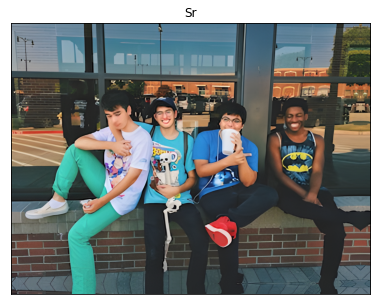

In [5]:
visualize(sr=res)

# export to onnx

In [6]:
input_names = ["input0"]
output_names = ["output0"]
output_onnx = "RealESRGAN_x4plus.onnx"
torch_out = torch.onnx._export(model, img, output_onnx, export_params=True, verbose=True,
                               input_names=input_names, output_names=output_names)